In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde
import re

_display_plot_rcParams = {
    'figure.figsize' : [10,7],
    'figure.dpi' : 100,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'xtick.minor.visible' : True,
    'ytick.right' : True,
    'ytick.direction' : 'in',
    'ytick.minor.visible' : True,
    'font.size' : 12,
    'mathtext.default' : 'regular',
    'font.family' : 'DejaVu Serif',
    }
matplotlib.rcParams.update(_display_plot_rcParams)

First, generate the initial dimerization. 2- and 3-D walks with lengths $N\in[100,100000]$ are generated, and saved to `polymers/data/dimers`.

In [ ]:
! ../bin/generate_dimers.py

Then, run the experiment. The experiment will run the pivot algorithm $10^7$ times, sampling the observables $\langle R_e^2 \rangle$, $\langle R_g^2 \rangle$, and $\langle R_m^2 \rangle$ for each of the equilibrized states every $10^4$ pivots (or steps). This results in $10^3$ samples for each observable. The results are saved to `.csv` files in `polymers/data/dimers/`.

Of course, you'd want to make batch sizes much larger than $10^4$ pivots (and have more than $1000$ samples...), but this is just being run on a laptop.

In [ ]:
! ../bin/critical_exp.py

In [2]:
def get_maxima(dataset):
    kernel = gaussian_kde(dataset)
    kernel.set_bandwidth(bw_method=0.3)
    
    min,max = dataset.min(),dataset.max()
    x = np.linspace(min,max,1000)
    prob = kernel.evaluate(x)
    maxima = x[prob.argmax()]
    return maxima

def read_data(files):
    data = np.zeros((len(files),4))
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        
        # file is of the form dimer_d{dim}dimer{N}.csv
        dim,N = re.findall(r'\d+',f)
        dim = int(dim)
        N = int(N)
        Re2 = get_maxima(df['Re2'])
        Rg2 = get_maxima(df['Rg2'])
        Rm2 = get_maxima(df['Rm2'])
        
        data[i] = [N,Re2,Rg2,Rm2]
    return data

d2_files = sorted(glob('dimer_d2*.csv'))
d3_files = sorted(glob('dimer_d3*.csv'))
d2_data = read_data(d2_files)
d3_data = read_data(d3_files)

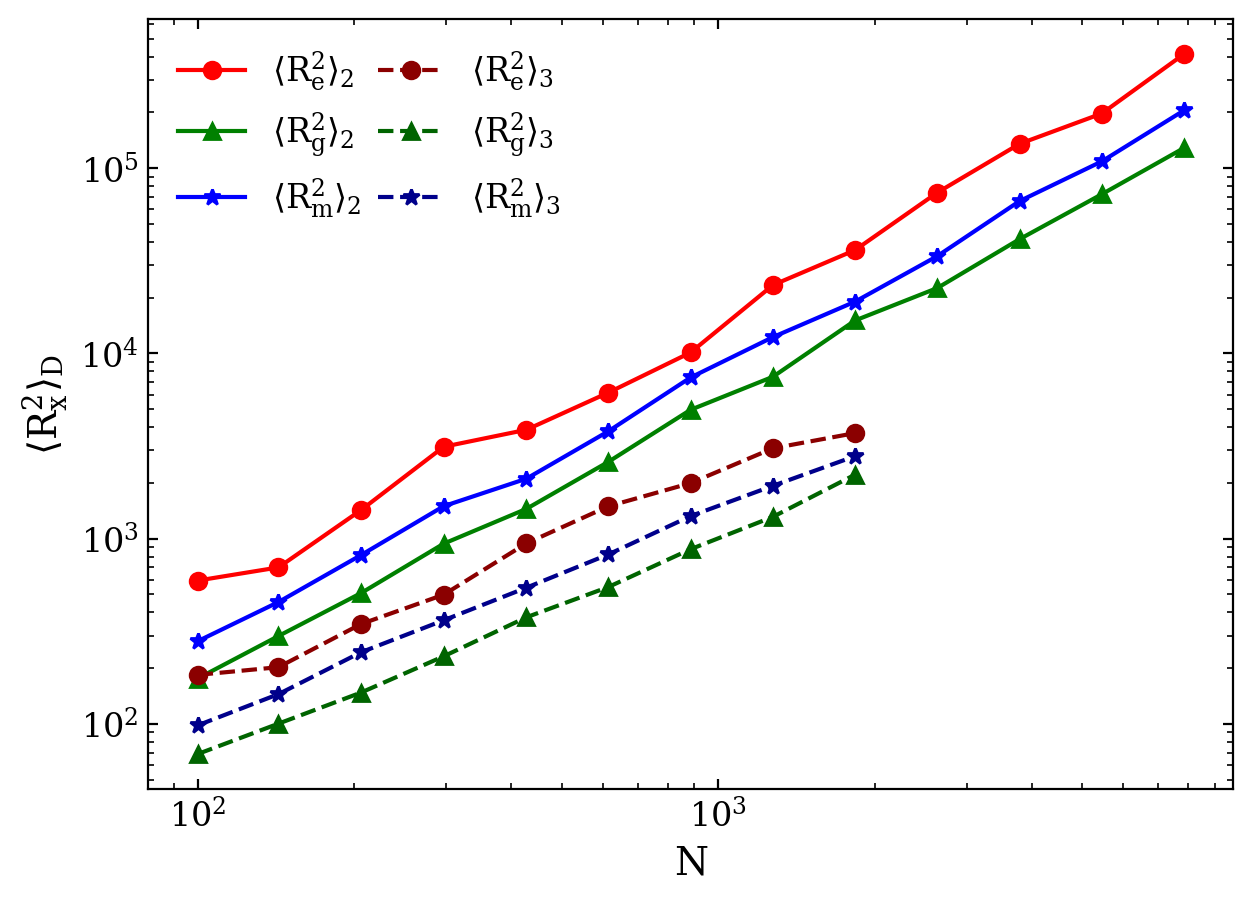

In [11]:
plt.figure(figsize=(7,5),dpi=200)
def darken(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    c = mc.cnames[color]
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

for i,data in enumerate([d2_data,d3_data]):
    ls = ['-','--'][i]
    D = [2,3][i]
    colors = [['red','green','blue'],['darkred','darkgreen', 'darkblue']][i]
    marker = ['o', '^', '*']
    plt.plot(data[:,0],data[:,1],ls,label=f'$\\langle R_e^2 \\rangle_{{{D}}}$', color=colors[0], marker=marker[0])
    plt.plot(data[:,0],data[:,2],ls,label=f'$\\langle R_g^2 \\rangle_{{{D}}}$', color=colors[1], marker=marker[1])
    plt.plot(data[:,0],data[:,3],ls,label=f'$\\langle R_m^2 \\rangle_{{{D}}}$', color=colors[2], marker=marker[2])
# plt.xlim(0,)
# plt.ylim(0,)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N', fontsize=14)
plt.ylabel('$\\langle R_x^2 \\rangle_D$', fontsize=14)
plt.legend(frameon=False, fontsize=12, ncols=2, columnspacing=0.5)
plt.show()

In [4]:
from functools import lru_cache
from scipy.optimize import curve_fit

def Rx2(N, D_x, nu):
    return D_x*N**(2*nu)

def estimate_vars_Rx2(data, x):
    x_to_i = {'e':1, 'g':2, 'm':3}
    N = data[:,0]
    Rx2_data = data[:,x_to_i[x]]
    popt, pcov = curve_fit(Rx2, N, Rx2_data, p0=[1,0.5])
    return popt, np.sqrt(np.diag(pcov))

def estimate_nu(dD_data):
    estimates = [estimate_vars_Rx2(dD_data, x) for x in ['e','g','m']]
    nu_estimates = np.array([[x[0][1],x[1][1]] for x in estimates])
    weights = 1/nu_estimates[:,1]**2
    weighted_mean = np.average(nu_estimates[:,0], weights=weights)
    combined_error = (1 / weights.sum()) ** 0.5
    return weighted_mean, combined_error

def estimate_Dx(data, x):
    popt, pcov = estimate_vars_Rx2(data, x)
    return popt[0], pcov[0]

In [14]:
from IPython.display import Markdown
import pandas as pd


def to_shorthand(value, uncertainty):
    """
    Convert a value with uncertainty to shorthand notation.

    Parameters:
    value (float): The estimated value.
    uncertainty (float): The uncertainty in the value.

    Returns:
    str: The value with uncertainty in shorthand notation.
    """
    if uncertainty == 0:
        raise ValueError("Uncertainty cannot be zero.")
    
    uncertainty_digits = -int(np.floor(np.log10(abs(uncertainty)))) + 1
    if uncertainty_digits < 0:
        rounded_uncertainty = round(uncertainty, -uncertainty_digits)
    else:
        rounded_uncertainty = round(uncertainty, uncertainty_digits)
    rounded_value = round(value, uncertainty_digits)
    int_uncertainty = int(rounded_uncertainty * (10 ** uncertainty_digits))
    return f"{rounded_value}({int_uncertainty})"

"""Make a table of the form
| D | $\\nu$ | $D_e$ | $D_g$ | $D_m$ |
|---|--------|-------|-------|-------|
| 2 |        |       |       |       |
| 3 |        |       |       |       |
--------------------------------------
"""

table = pd.DataFrame(columns=['D','$\\nu$','$D_e$','$D_g$','$D_m$'])
table['D'] = [2,3]

nus = []
Des = []
Dgs = []
Dms = []
for i,data in enumerate([d2_data,d3_data]):
    nu,nu_err = estimate_nu(data)
    De, De_err = estimate_Dx(data, 'e')
    Dg, Dg_err = estimate_Dx(data, 'g')
    Dm, Dm_err = estimate_Dx(data, 'm')
    nus.append(to_shorthand(nu,nu_err))
    Des.append(to_shorthand(De,De_err))
    Dgs.append(to_shorthand(Dg,Dg_err))
    Dms.append(to_shorthand(Dm,Dm_err))
    
table['$\\nu$'] = nus
table['$D_e$'] = Des
table['$D_g$'] = Dgs
table['$D_m$'] = Dms

table.to_latex('results.tex', index=False, escape=False)
Markdown(table.to_markdown(index=False))

/var/folders/w7/xwdclb5101q6zdxfxf7910pr0000gp/T/ipykernel_28568/3755920015.py:58: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('results.tex', index=False, escape=False)


|   D | $\nu$      | $D_e$     | $D_g$     | $D_m$     |
|----:|:-----------|:----------|:----------|:----------|
|   2 | 0.7859(60) | 0.136(80) | 0.113(14) | 0.099(23) |
|   3 | 0.5722(84) | 2.8(14)   | 0.161(35) | 0.72(11)  |